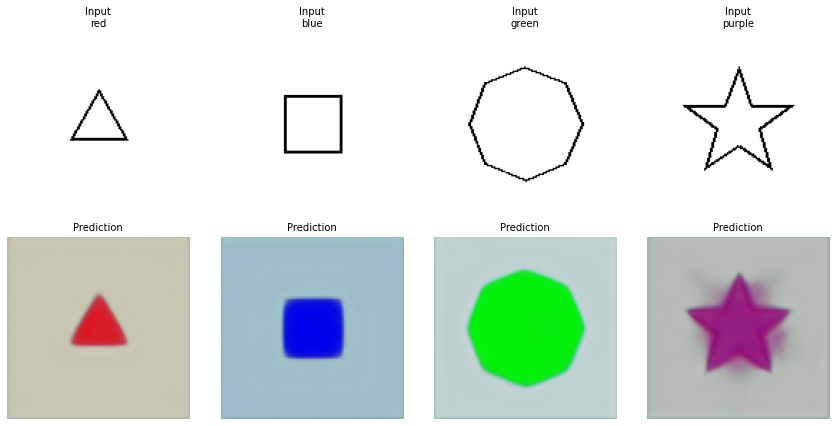

✅ Predictions saved individually in 'predictions/'
✅ Combined 4x4 results saved at: predictions/combined_results_4x4.png


In [3]:
import warnings
warnings.filterwarnings("ignore")

import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from model import UNet
from dataset import PolygonColorDataset
import os

# Create folder for saving predictions
os.makedirs("predictions", exist_ok=True)

# Load dataset to get color mapping
dataset = PolygonColorDataset("dataset/dataset", split="training")
n_colors = len(dataset.colors)
color_to_idx = dataset.color_to_idx

# Load trained model
model = UNet(in_channels=1, n_classes=3, n_colors=n_colors)
model.load_state_dict(torch.load("unet_polygon.pth", map_location="cpu"))
model.eval()

# Transform
transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])

# Examples to test (polygon image path, color name)
examples = [
    ("dataset/dataset/validation/inputs/triangle.png", "red"),
    ("dataset/dataset/validation/inputs/square.png", "blue"),
    ("dataset/dataset/validation/inputs/octagon.png", "green"),
    ("dataset/dataset/validation/inputs/star.png", "purple"),
]

# Prepare a 4x4 figure layout (Inputs and Predictions alternating)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for idx, (img_path, color_name) in enumerate(examples):
    polygon_img = Image.open(img_path).convert("L")
    polygon_tensor = transform(polygon_img).unsqueeze(0)

    # One-hot encode color
    color_onehot = torch.zeros(1, n_colors)
    color_onehot[0, color_to_idx[color_name]] = 1.0

    # Predict
    with torch.no_grad():
        output = model(polygon_tensor, color_onehot)

    pred_img = output.squeeze(0).permute(1, 2, 0).numpy()

    # Save predicted image individually
    pred_pil = Image.fromarray((pred_img * 255).astype("uint8"))
    save_path = os.path.join("predictions", f"{os.path.splitext(os.path.basename(img_path))[0]}_{color_name}.png")
    pred_pil.save(save_path)

    # Row and column placement
    axes[0, idx].imshow(polygon_img, cmap="gray")
    axes[0, idx].set_title(f"Input\n{color_name}", fontsize=10)
    axes[0, idx].axis("off")

    axes[1, idx].imshow(pred_img)
    axes[1, idx].set_title("Prediction", fontsize=10)
    axes[1, idx].axis("off")

plt.tight_layout()

# Save combined plot
combined_path = os.path.join("predictions", "combined_results_4x4.png")
plt.savefig(combined_path, dpi=300)
plt.show()

print(f"✅ Predictions saved individually in 'predictions/'")
print(f"✅ Combined 4x4 results saved at: {combined_path}")
